## Direct Shooting 法を用いた最適化

### 最適化の概要
Direct Shooting 法を用いた最適化の例として，時間に対する **原料流量** \( u(t) \) の変化スケジュールを決定する。
制御変数を直接最適化し、状態方程式を数値積分することで最適軌道を求める

### 状態方程式（動的システムの記述）
化学反応器の動作を表す非線形微分方程式は以下の通り。

$$
\frac{dC_A}{dt} = \frac{F_{in}}{V} (C_{A,in} - C_A) - k C_A
$$

ただし，
- $C_A$     : 反応器内の物質 A の濃度
- $F_{in}$  : 原料の流量（最適化すべき制御変数）
- $V$       : 反応器の体積（定数）
- $C_{A,in}$: 供給流の A の濃度（定数）
- $k$       : 反応速度定数（定数）

### 最適化の目的
時間 $T$ の範囲内で **反応器内の濃度を所望の値に近づける** ような流量スケジュール $u(t)$ を求める。そのために、コスト関数として以下の形で定義する。

$$
J = \sum_{t=0}^{T} (C_A - C_{A,target})^2 + \lambda u(t)^2
$$

ここで、$\lambda$ は制御入力のペナルティを調整する重みを表す。



#### 1. Casadi を使用して求める

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      301
Number of nonzeros in inequality constraint Jacobian.:      101
Number of nonzeros in Lagrangian Hessian.............:      302

Total number of variables............................:      202
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      101
Total number of inequality constraints...............:      101
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      101
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  2.5250000e+01 0.00e+00 5.77e-01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

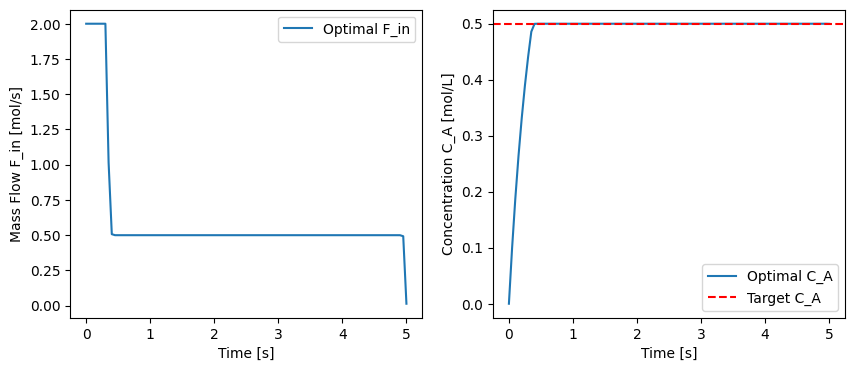

In [48]:
import casadi as ca
import numpy as np
import matplotlib.pyplot as plt

# 反応器のパラメータ
V = 1.0  # 体積
k = 0.5  # 反応速度定数
C_A_in = 1.0  # 供給流の濃度
C_A_target = 0.5  # 目標濃度

T_final = 5  # 最適化時間範囲
N = 100  # 制御入力の分割数（増加）

dt = T_final / N  # 時間ステップ

def reactor_dynamics(C_A, F_in):
    return (F_in / V) * (C_A_in - C_A) - k * C_A

# CasADiで最適化問題を定義
opti = ca.Opti()
F_in = opti.variable(N+1)  # 制御入力 (F_in)
C_A = opti.variable(N+1)  # 状態変数 (C_A)

# 初期条件
opti.subject_to(C_A[0] == 0.0)

# 離散時間シミュレーション (Euler法)
for i in range(N):
    C_A_next = C_A[i] + dt * reactor_dynamics(C_A[i], F_in[i])
    opti.subject_to(C_A[i+1] == C_A_next)

# 目的関数 (出口濃度の偏差 + エネルギーコスト)
cost = ca.sumsqr(C_A - C_A_target) + 0.00001 * ca.sumsqr(F_in)  # コスト係数を減らす
opti.minimize(cost)

# 制約条件 (流量範囲)
opti.subject_to(opti.bounded(0, F_in, 2.0))

# ソルバー設定
opti.solver('ipopt')
sol = opti.solve()

# 結果取得
time_opt = np.linspace(0, T_final, N+1)
F_opt = sol.value(F_in)
C_A_opt = sol.value(C_A)

# 可視化
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(time_opt, F_opt, label="Optimal F_in")
plt.xlabel("Time [s]")
plt.ylabel("Mass Flow F_in [mol/s]")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(time_opt, C_A_opt, label="Optimal C_A")
plt.axhline(C_A_target, linestyle="--", color="red", label="Target C_A")
plt.xlabel("Time [s]")
plt.ylabel("Concentration C_A [mol/L]")
plt.legend()

plt.show()

#### 2. SciPyを使用して求める

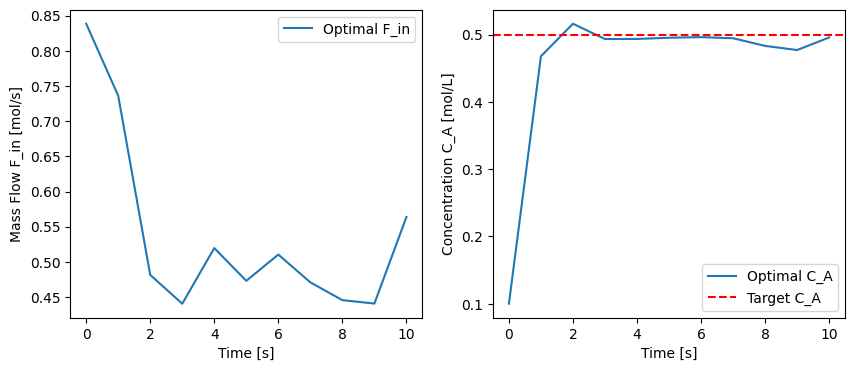

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.optimize import minimize

# 反応器のパラメータ
V = 1.0             # 体積
k = 0.5             # 反応速度定数
C_A_in = 1.0        # 供給流の濃度
C_A_target = 0.5    # 目標濃度

T_final = 10        # 最適化時間範囲
N = 10              # 制御入力の分割数（F_inをN個の区間で最適化）

# 反応器の状態方程式
def reactor_dynamics(t, C_A, F_in):
    return (F_in / V) * (C_A_in - C_A) - k * C_A

# シミュレーション関数
def simulate(F_in_schedule):
    time_grid = np.linspace(0, T_final, N+1)
    C_A_0 = [0.1]  # 初期濃度
    F_interp = lambda t: np.interp(t, time_grid, F_in_schedule)
    sol = solve_ivp(lambda t, C: reactor_dynamics(t, C, F_interp(t)), [0, T_final], C_A_0, t_eval=time_grid)
    return sol.t, sol.y[0]

# 目的関数 (出口濃度の偏差＋エネルギーコスト)
def objective(F_in_schedule):
    _, C_A_values = simulate(F_in_schedule)
    return np.sum((C_A_values - C_A_target)**2) + 0.01 * np.sum(F_in_schedule**2)
# 最適化の初期値
F_init = np.linspace(0.5, 1.0, N+1)  # 初期の流量スケジュール

# 最適化実行
bounds = [(0.1, 2.0)] * (N+1)  # 制御変数の範囲
result = minimize(objective, F_init, bounds=bounds, method='L-BFGS-B')

# 最適スケジュールの取得
F_opt = result.x

# シミュレーションと可視化
time_opt, C_A_opt = simulate(F_opt)
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(time_opt, F_opt, label="Optimal F_in")
plt.xlabel("Time [s]")
plt.ylabel("Mass Flow F_in [mol/s]")
plt.legend()

plt.subplot(1,2,2)
plt.plot(time_opt, C_A_opt, label="Optimal C_A")
plt.axhline(C_A_target, linestyle="--", color="red", label="Target C_A")
plt.xlabel("Time [s]")
plt.ylabel("Concentration C_A [mol/L]")
plt.legend()

plt.show()